In [1]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import optuna

In [2]:
#data
train=pd.read_csv("dataset/train_features.csv")
y=pd.read_csv("dataset/train_labels.csv")
test=pd.read_csv("dataset/test_features.csv")
ss=pd.read_csv("dataset/submission_format.csv")
test_ground_truth=pd.read_csv("dataset/sdoh_test_labels.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [8]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [9]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [10]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

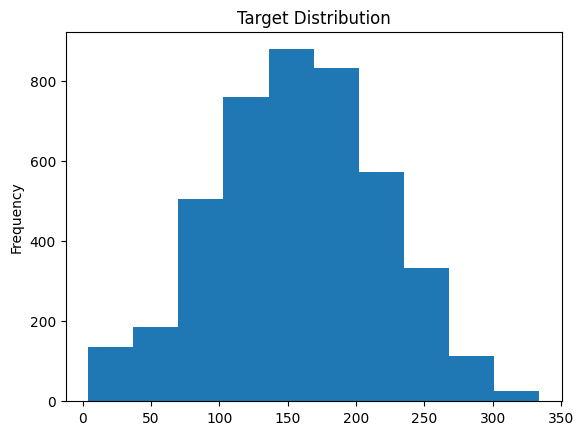

In [11]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [12]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    return data

In [13]:
def get_cat_cols(data):
    # Get the columns with object datatype
    cat_columns=[]
    dummies=[]
    for col in data.columns:
        if data[col].dtype=='object' and 'uid' not in col:
            cat_columns.append(col)
            dummies.append(col)
        elif data[col].dtype!='object' and 'uid' not in col and (data[col].max()==1.0):
            cat_columns.append(col)
            data[col].fillna(0, inplace=True)
        else:
            continue
    return cat_columns, dummies

In [14]:
def encode_cat_cols(train_data, cat_cols, dummy_cols):
    enc = OneHotEncoder()
    enc.fit(train_data[dummy_cols])
    encoded_train_data=enc.transform(train_data[dummy_cols]).toarray()
    feature_names = enc.get_feature_names_out(dummy_cols)
    train_data.drop(columns=dummy_cols, inplace=True)
    encoded_train_df = pd.DataFrame(encoded_train_data, columns=feature_names)
    train_data[feature_names]=encoded_train_df[feature_names]
    return train_data, feature_names

In [15]:
y=merged_df['composite_score']
data_processed=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data_processed = feature_engineering(data_processed)
cat_cols, dummy_cols = get_cat_cols(data_processed)
data_processed, dummy_feature_names=encode_cat_cols(data_processed, cat_cols, dummy_cols)
data_processed=data_processed.drop(columns=['composite_score'],axis=1)

for col in data_processed.columns: 
    if round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>50:
        data_processed.drop(columns=col, inplace=True)
    elif round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>5:
        print(col,round((data_processed[col].isna().sum() /len(data_processed)*100), 2), '% missing')
        data_processed[col].fillna(0, inplace=True)
    else: 
        data_processed[col].fillna(0, inplace=True)
        data_processed[col].fillna(0, inplace=True)

/tmp/ipykernel_3000384/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_3000384/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_3000384/2658724754.py:13: FutureWarning: Downcasting behavior i

n_mar_03 33.83 % missing
edu_gru_03 33.55 % missing
glob_hlth_03 36.99 % missing
n_adl_03 33.5 % missing
n_iadl_03 36.99 % missing
n_depr_03 37.1 % missing
n_illnesses_03 33.31 % missing
decis_personal_03 37.17 % missing
glob_hlth_12 5.8 % missing
n_iadl_12 5.84 % missing
n_depr_12 6.52 % missing
bmi_12 12.48 % missing
memory_12 6.72 % missing
rearnings_03 33.37 % missing
searnings_03 49.98 % missing
hincome_03 34.01 % missing
hinc_business_03 32.98 % missing
hinc_rent_03 32.98 % missing
hinc_assets_03 32.98 % missing
hinc_cap_03 32.98 % missing
rinc_pension_03 33.37 % missing
sinc_pension_03 49.98 % missing
searnings_12 35.19 % missing
sinc_pension_12 35.19 % missing


/tmp/ipykernel_3000384/3102208485.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_processed[col].fillna(0, inplace=True)
/tmp/ipykernel_3000384/3102208485.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

hincome_change 37.28 % missing
niadl_change 41.13 % missing
adl_change 36.4 % missing
depr_change 41.65 % missing
glob_hlth_change 41.1 % missing
edu_gru_change 36.09 % missing
illnesses_change 36.29 % missing


In [16]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data = feature_engineering(data)
data=data.drop(columns=['composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

/tmp/ipykernel_3000384/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_3000384/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_3000384/2658724754.py:13: FutureWarning: Downcasting behavior i

In [17]:
#separate train and test
merged_df_processed=data_processed[:len(merged_df)]
merged_test_processed=data_processed[len(merged_df):]

In [18]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [19]:
merged_df.shape

(4343, 196)

In [21]:
merged_df_processed.shape

(4343, 349)

In [21]:
# Define an objective function for Optuna for each model
def objective_lightgbm(trial, train_X, train_y, val_X, val_y):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        "random_state": 42,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),                  # narrower range
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),      # narrower range
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000)  
    }

    train_data = lgb.Dataset(train_X, label=train_y)
    val_data = lgb.Dataset(val_X, label=val_y, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=params['n_estimators'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=False),
        ]
    )

    preds = model.predict(val_X, num_iteration=model.best_iteration)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_catboost(trial, train_X, train_y, val_X, val_y):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),  # narrower max depth
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg
        'iterations': trial.suggest_int('iterations', 50, 5000)    
    }

    model = CatBoostRegressor(
        **params,
        loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=0, early_stopping_rounds = 500,
        random_state=42
    )
    model.fit(train_X, train_y, eval_set=(val_X, val_y))

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_xgboost(trial, train_X, train_y, val_X, val_y):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
        'max_depth': trial.suggest_int('max_depth', 2, 10),                      # narrower depth
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),        # narrower range
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000)    
    }

    model = XGBRegressor(**params,
                         enable_categorical=True,
                         eval_metric=root_mean_squared_error,
                         early_stopping_rounds=500,
                         random_state=42)
    model.fit(
        train_X, train_y,
        eval_set=[(val_X, val_y)],
        verbose=False,
    )

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_randomforest(trial, train_X, train_y, val_X, val_y):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 20, log=True),    # narrower range
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),# narrower range
        'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)     # ensure at least 100 trees
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(train_X, train_y)

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

# Run Optuna for each model and store the best parameters
best_params = {}
for model_name, objective in zip(
    ['lightgbm', 'RandomForest', 'XGBoost', 'CatBoost'],
    [objective_lightgbm, objective_randomforest, objective_xgboost, objective_catboost]
):
    study = optuna.create_study(direction='minimize')
    if model_name == 'RandomForest':
        unique_uids = merged_df_processed['uid'].unique()
        train_ids, val_ids = train_test_split(unique_uids, test_size=0.2, random_state=42)
        keep_train = merged_df_processed['uid'].isin(train_ids)
        keep_val = merged_df_processed['uid'].isin(val_ids)
        train_X, val_X = merged_df_processed[keep_train],merged_df_processed[keep_val]
        train_X.drop(columns=['uid'], inplace=True)
        val_X.drop(columns=['uid'], inplace=True)
        train_y, val_y= y[keep_train], y[keep_val]
        # train_X, val_X, train_y, val_y = train_test_split(merged_df_processed, y, test_size=0.2, random_state=42)
    else:
        unique_uids = merged_df['uid'].unique()
        train_ids, val_ids = train_test_split(unique_uids, test_size=0.2, random_state=42)
        keep_train = merged_df['uid'].isin(train_ids)
        keep_val = merged_df['uid'].isin(val_ids)
        train_X, val_X = merged_df[keep_train],merged_df[keep_val]
        train_X.drop(columns=['uid'], inplace=True)
        val_X.drop(columns=['uid'], inplace=True)
        train_y, val_y= y[keep_train], y[keep_val]
        # train_X, val_X, train_y, val_y = train_test_split(merged_df, y, test_size=0.2, random_state=42)
    study.optimize(lambda trial: objective(trial, train_X, train_y, val_X, val_y), n_trials=100, n_jobs=-1, show_progress_bar=True)
    best_params[model_name] = study.best_params
    print(f"Best params for {model_name}: {study.best_params}")
    print(f"Best RMSE for {model_name}: {study.best_value}")

[I 2024-12-17 19:31:26,663] A new study created in memory with name: no-name-e8079bda-b698-4e98-b56c-06d6e0ec74e9
/tmp/ipykernel_26601/135298176.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_26601/135298176.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204:

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data p

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 194
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] [I 2024-12-17 19:31:51,814] Trial 8 finished with value: 41.35430146210876 and parameters: {'learning_rate': 0.008303621180451597, 'num_leaves': 82, 'feature_fraction': 0.9051732025981014, 'min_child_samples': 66, 'n_estimators': 2195}. Best is trial 5 with value: 41.01757158695315.
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Warning] No further splits with positive gain, best g

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 3458, n

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:32:41,600] Trial 32 finished with value: 41.099653956597265 and parameters: {'learning_rate': 0.01041423105457352, 'num_leaves': 44, 'feature_fraction': 0.86605741396329, 'min_child_samples': 76, 'n_estimators': 4103}. Best is trial 36 with value: 40.71136067218582.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[I 2024-12-17 19:32:41,775] Trial 38 finished with value: 40.78647997701058 and parameters: {'learning_rate': 0.026845245180089124, 'num_leaves': 11, 'feature_fraction': 0.9443390722517035, 'min_child_samples': 77, 'n_estimators': 4262}. Best is trial 36 with value: 40.71136067218582.


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[I 2024-12-17 19:32:43,390] Trial 40 finished with value: 40.71980197119063 and parameters: {'learning_rate': 0.02876115563467668, 'num_leaves': 10, 'feature_fraction': 0.9319863592360202, 'min_child_samples': 73, 'n_estimators': 4558}. Best is trial 36 with value: 40.71136067218582.


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[I 2024-12-17 19:32:43,860] Trial 39 finished with value: 40.74388945897111 and parameters: {'learning_rate': 0.026163336038523874, 'num_leaves': 13, 'feature_fraction': 0.868428503966183, 'min_child_samples': 76, 'n_estimators': 4571}. Best is trial 36 with value: 40.71136067218582.


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[I 2024-12-17 19:32:45,450] Trial 43 finished with value: 40.734582085270866 and parameters: {'learning_rate': 0.02864987922902174, 'num_leaves': 10, 'feature_fraction': 0.8688268250834, 'min_child_samples': 73, 'n_estimators': 4692}. Best is trial 36 with value: 40.71136067218582.


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[I 2024-12-17 19:32:45,796] Trial 41 finished with value: 40.7452127112353 and parameters: {'learning_rate': 0.014122555286664137, 'num_leaves': 10, 'feature_fraction': 0.9420420641298547, 'min_child_samples': 70, 'n_estimators': 4682}. Best is trial 36 with value: 40.71136067218582.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the 

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:32:47,317] Trial 42 finished with value: 40.69473174611625 and parameters: {'learning_rate': 0.01474214331261038, 'num_leaves': 10, 'feature_fraction': 0.9429909731747476, 'min_child_samples': 73, 'n_estimators': 4536}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:32:48,349] Trial 44 finished with value: 40.70288256415379 and parameters: {'learning_rate': 0.015843193541889483, 'num_leaves': 14, 'feature_fraction': 0.8699676613430937, 'min_child_samples': 55, 'n_estimators': 4585}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:32:50,684] Trial 47 finished with value: 40.77854336800046 and parameters: {'learning_rate': 0.016398307555298065, 'num_leaves': 15, 'feature_fraction': 0.8187212212825999, 'min_child_samples': 59, 'n_estimators': 4867}. Best is trial 42 with value: 40.69473174611625.


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[I 2024-12-17 19:32:53,150] Trial 46 finished with value: 40.81473235355056 and parameters: {'learning_rate': 0.015362093272606878, 'num_leaves': 25, 'feature_fraction': 0.8379351078777529, 'min_child_samples': 58, 'n_estimators': 4817}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:32:54,364] Trial 48 finished with value: 40.898764152849985 and parameters: {'learning_rate': 0.015022513540311972, 'num_leaves': 24, 'feature_fraction': 0.8173885938610612, 'min_child_samples': 57, 'n_estimators': 4832}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:32:55,515] Trial 49 finished with value: 40.90454721473715 and parameters: {'learning_rate': 0.017901163035409392, 'num_leaves': 25, 'feature_fraction': 0.8380313299185149, 'min_child_samples': 57, 'n_estimators': 4792}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 194
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:32:55,972] Trial 50 finished with value: 40.93501964641725 and parameters: {'learning_rate': 0.016527261396767152, 'num_leaves': 25, 'feature_fraction': 0.8319758445316127, 'min_child_samples': 57, 'n_estimators': 4963}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:32:56,952] Trial 45 finished with value: 41.07608049319887 and parameters: {'learning_rate': 0.007032056952862111, 'num_leaves': 26, 'feature_fraction': 0.8226125635253797, 'min_child_samples': 61, 'n_estimators': 4549}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 194
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:33:01,350] Trial 51 finished with value: 41.01493198194496 and parameters: {'learning_rate': 0.008449116910351369, 'num_leaves': 27, 'feature_fraction': 0.8266095708371957, 'min_child_samples': 57, 'n_estimators': 4451}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 194
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:33:02,197] Trial 52 finished with value: 40.87895532642613 and parameters: {'learning_rate': 0.008272677349078786, 'num_leaves': 25, 'feature_fraction': 0.8258613250646268, 'min_child_samples': 56, 'n_estimators': 4396}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:33:04,283] Trial 54 finished with value: 40.925239699272396 and parameters: {'learning_rate': 0.007404685970201022, 'num_leaves': 17, 'feature_fraction': 0.9175107079844729, 'min_child_samples': 49, 'n_estimators': 4990}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:33:04,673] Trial 55 finished with value: 40.926556675677425 and parameters: {'learning_rate': 0.007767553167830525, 'num_leaves': 16, 'feature_fraction': 0.9178529503611419, 'min_child_samples': 65, 'n_estimators': 4505}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:33:05,494] Trial 53 finished with value: 40.808744037378 and parameters: {'learning_rate': 0.008653223833456467, 'num_leaves': 25, 'feature_fraction': 0.9202427239587064, 'min_child_samples': 56, 'n_estimators': 4431}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[I 2024-12-17 19:33:06,975] Trial 57 finished with value: 40.973265784189955 and parameters: {'learning_rate': 0.008137530379244098, 'num_leaves': 17, 'feature_fraction': 0.9232774752029138, 'min_child_samples': 50, 'n_estimators': 4416}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score 155.317235
[I 2024-12-17 19:33:07,227] Trial 56 finished with value: 40.824946059369054 and parameters: {'learning_rate': 0.007409191714737052, 'num_leaves': 17, 'feature_fraction': 0.9198598006439591, 'min_child_samples': 48, 'n_estimators': 4437}. Best is trial 42 with value: 40.69473174611625.


/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[I 2024-12-17 19:33:08,193] Trial 58 finished with value: 40.91027702211167 and parameters: {'learning_rate': 0.00823635887214312, 'num_leaves': 17, 'feature_fraction': 0.9147895338448122, 'min_child_samples': 48, 'n_estimators': 4313}. Best is trial 42 with value: 40.69473174611625.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the 

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-17 19:33:16,097] Trial 68 finished with value: 40.77699667016665 and parameters: {'learning_rate': 0.03877466221506082, 'num_leaves': 13, 'feature_fraction': 0.9668517445713671, 'min_child_samples': 70, 'n_

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008135 secon

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010348 secon

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-17 19:33:25,817] Trial 80 finished with value: 40.73337945198479 and parameters: {'learning_rate': 0.02741441128704323, 'num_leaves': 10, 'feature_fraction': 0.8742

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 155.317235[LightGBM] [Warning] No further splits with positive gain, best gain

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010871 secon

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you c

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with pos

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_26601/135298176.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),   # narrower range
/tmp/ipykernel_26601/135298176.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # slightly adjusted
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2024-12-17 19:34:09,455] A new study created in memory with name: no-name-d225e495-6658-438c-996c-c0b37f763fc2


[I 2024-12-17 19:34:09,452] Trial 87 finished with value: 41.45639338813581 and parameters: {'learning_rate': 0.0010648589791318025, 'num_leaves': 56, 'feature_fraction': 0.9324394395672226, 'min_child_samples': 40, 'n_estimators': 3875}. Best is trial 97 with value: 40.666051742072796.
Best params for lightgbm: {'learning_rate': 0.006420854740302429, 'num_leaves': 12, 'feature_fraction': 0.9808229196913436, 'min_child_samples': 77, 'n_estimators': 2814}
Best RMSE for lightgbm: 40.666051742072796


/tmp/ipykernel_26601/135298176.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_26601/135298176.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be rem

[I 2024-12-17 19:34:12,572] Trial 5 finished with value: 46.81883595451607 and parameters: {'max_depth': 2, 'min_samples_leaf': 5, 'max_features': 0.5616423018927255, 'n_estimators': 254}. Best is trial 5 with value: 46.81883595451607.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:16,137] Trial 1 finished with value: 41.65392699628306 and parameters: {'max_depth': 9, 'min_samples_leaf': 9, 'max_features': 0.6554456125206287, 'n_estimators': 164}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:19,248] Trial 0 finished with value: 42.25389186306859 and parameters: {'max_depth': 6, 'min_samples_leaf': 10, 'max_features': 0.4607961184769813, 'n_estimators': 441}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:20,219] Trial 3 finished with value: 41.6722526939932 and parameters: {'max_depth': 12, 'min_samples_leaf': 8, 'max_features': 0.7578408454607702, 'n_estimators': 208}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:22,320] Trial 6 finished with value: 46.51233765400404 and parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'max_features': 0.8843379751578078, 'n_estimators': 934}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:23,812] Trial 4 finished with value: 43.31071874562809 and parameters: {'max_depth': 4, 'min_samples_leaf': 6, 'max_features': 0.8674721514067787, 'n_estimators': 561}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:26,406] Trial 2 finished with value: 41.737068367168 and parameters: {'max_depth': 13, 'min_samples_leaf': 4, 'max_features': 0.36156100078768166, 'n_estimators': 504}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:28,520] Trial 11 finished with value: 46.60177911748904 and parameters: {'max_depth': 2, 'min_samples_leaf': 3, 'max_features': 0.9395604288910515, 'n_estimators': 576}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:28,863] Trial 12 finished with value: 45.784261644117755 and parameters: {'max_depth': 3, 'min_samples_leaf': 6, 'max_features': 0.32466284104956467, 'n_estimators': 703}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:29,568] Trial 10 finished with value: 42.32533051889756 and parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'max_features': 0.718650451988545, 'n_estimators': 327}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:33,873] Trial 17 finished with value: 41.82973783654129 and parameters: {'max_depth': 20, 'min_samples_leaf': 10, 'max_features': 0.5952022074292049, 'n_estimators': 116}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:37,590] Trial 15 finished with value: 46.60467477138541 and parameters: {'max_depth': 2, 'min_samples_leaf': 5, 'max_features': 0.9715359006184066, 'n_estimators': 689}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:39,241] Trial 7 finished with value: 41.7375308072468 and parameters: {'max_depth': 19, 'min_samples_leaf': 10, 'max_features': 0.4930724793935151, 'n_estimators': 872}. Best is trial 1 with value: 41.65392699628306.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:40,104] Trial 18 finished with value: 41.65235806999726 and parameters: {'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.742005850396173, 'n_estimators': 132}. Best is trial 18 with value: 41.65235806999726.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:40,914] Trial 16 finished with value: 44.66669432365379 and parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'max_features': 0.5944111657626627, 'n_estimators': 915}. Best is trial 18 with value: 41.65235806999726.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:44,500] Trial 19 finished with value: 41.68527676182616 and parameters: {'max_depth': 11, 'min_samples_leaf': 8, 'max_features': 0.7638425833086036, 'n_estimators': 134}. Best is trial 18 with value: 41.65235806999726.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:45,650] Trial 21 finished with value: 41.73164719891827 and parameters: {'max_depth': 9, 'min_samples_leaf': 8, 'max_features': 0.7210653393713322, 'n_estimators': 117}. Best is trial 18 with value: 41.65235806999726.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:45,944] Trial 8 finished with value: 41.73401588183799 and parameters: {'max_depth': 13, 'min_samples_leaf': 10, 'max_features': 0.5732338654731672, 'n_estimators': 879}. Best is trial 18 with value: 41.65235806999726.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:46,992] Trial 13 finished with value: 41.63945257846888 and parameters: {'max_depth': 10, 'min_samples_leaf': 7, 'max_features': 0.8463168737062743, 'n_estimators': 440}. Best is trial 13 with value: 41.63945257846888.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:47,225] Trial 20 finished with value: 41.62232933731077 and parameters: {'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.7423454711064524, 'n_estimators': 150}. Best is trial 20 with value: 41.62232933731077.
[I 2024-12-17 19:34:47,408] Trial 22 finished with value: 41.793569534475026 and parameters: {'max_depth': 9, 'min_samples_leaf': 8, 'max_features': 0.750332594201295, 'n_estimators': 126}. Best is trial 20 with value: 41.62232933731077.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:57,825] Trial 23 finished with value: 41.822409870912026 and parameters: {'max_depth': 8, 'min_samples_leaf': 8, 'max_features': 0.666654220160427, 'n_estimators': 359}. Best is trial 20 with value: 41.62232933731077.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:58,722] Trial 9 finished with value: 41.94967036325886 and parameters: {'max_depth': 7, 'min_samples_leaf': 4, 'max_features': 0.8926524767733399, 'n_estimators': 931}. Best is trial 20 with value: 41.62232933731077.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:34:59,097] Trial 24 finished with value: 41.833108117134486 and parameters: {'max_depth': 8, 'min_samples_leaf': 7, 'max_features': 0.6619649650477377, 'n_estimators': 361}. Best is trial 20 with value: 41.62232933731077.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:00,197] Trial 14 finished with value: 41.65477892288386 and parameters: {'max_depth': 20, 'min_samples_leaf': 8, 'max_features': 0.575539620696351, 'n_estimators': 854}. Best is trial 20 with value: 41.62232933731077.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:01,313] Trial 27 finished with value: 41.826543307403256 and parameters: {'max_depth': 7, 'min_samples_leaf': 7, 'max_features': 0.8308178620822053, 'n_estimators': 360}. Best is trial 20 with value: 41.62232933731077.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:01,764] Trial 25 finished with value: 41.80349634041573 and parameters: {'max_depth': 8, 'min_samples_leaf': 7, 'max_features': 0.8200291673650646, 'n_estimators': 326}. Best is trial 20 with value: 41.62232933731077.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:02,397] Trial 26 finished with value: 41.76967432769634 and parameters: {'max_depth': 8, 'min_samples_leaf': 7, 'max_features': 0.8297610526368314, 'n_estimators': 353}. Best is trial 20 with value: 41.62232933731077.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:02,805] Trial 28 finished with value: 41.85660245136369 and parameters: {'max_depth': 7, 'min_samples_leaf': 7, 'max_features': 0.8429999168608008, 'n_estimators': 354}. Best is trial 20 with value: 41.62232933731077.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:10,700] Trial 36 finished with value: 42.61417679654448 and parameters: {'max_depth': 5, 'min_samples_leaf': 9, 'max_features': 0.7961201373609204, 'n_estimators': 250}. Best is trial 20 with value: 41.62232933731077.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:14,634] Trial 29 finished with value: 41.54920113349135 and parameters: {'max_depth': 16, 'min_samples_leaf': 7, 'max_features': 0.8240804766753125, 'n_estimators': 274}. Best is trial 29 with value: 41.54920113349135.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:15,510] Trial 31 finished with value: 41.5552950473854 and parameters: {'max_depth': 16, 'min_samples_leaf': 7, 'max_features': 0.8152699889759055, 'n_estimators': 263}. Best is trial 29 with value: 41.54920113349135.
[I 2024-12-17 19:35:15,585] Trial 34 finished with value: 41.72362051905589 and parameters: {'max_depth': 16, 'min_samples_leaf': 9, 'max_features': 0.7866345188854802, 'n_estimators': 245}. Best is trial 29 with value: 41.54920113349135.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:15,858] Trial 30 finished with value: 41.536226240679476 and parameters: {'max_depth': 16, 'min_samples_leaf': 7, 'max_features': 0.8222940168211761, 'n_estimators': 285}. Best is trial 30 with value: 41.536226240679476.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:16,140] Trial 32 finished with value: 41.603013509323524 and parameters: {'max_depth': 16, 'min_samples_leaf': 7, 'max_features': 0.8174263787103221, 'n_estimators': 272}. Best is trial 30 with value: 41.536226240679476.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:16,993] Trial 35 finished with value: 41.55729360437497 and parameters: {'max_depth': 16, 'min_samples_leaf': 9, 'max_features': 0.8080297161715582, 'n_estimators': 250}. Best is trial 30 with value: 41.536226240679476.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:18,834] Trial 33 finished with value: 41.60438106307731 and parameters: {'max_depth': 16, 'min_samples_leaf': 7, 'max_features': 0.8126302271648226, 'n_estimators': 284}. Best is trial 30 with value: 41.536226240679476.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:20,375] Trial 37 finished with value: 41.701819975436656 and parameters: {'max_depth': 17, 'min_samples_leaf': 9, 'max_features': 0.7017422158245045, 'n_estimators': 191}. Best is trial 30 with value: 41.536226240679476.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:31,482] Trial 42 finished with value: 41.479240953386295 and parameters: {'max_depth': 15, 'min_samples_leaf': 6, 'max_features': 0.9275382250997984, 'n_estimators': 203}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:42,745] Trial 38 finished with value: 41.546594069239454 and parameters: {'max_depth': 16, 'min_samples_leaf': 9, 'max_features': 0.9129052377273322, 'n_estimators': 442}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:47,225] Trial 40 finished with value: 41.549605907102766 and parameters: {'max_depth': 16, 'min_samples_leaf': 6, 'max_features': 0.9261183864104015, 'n_estimators': 423}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:48,256] Trial 41 finished with value: 41.59565236820172 and parameters: {'max_depth': 15, 'min_samples_leaf': 6, 'max_features': 0.9260836521508895, 'n_estimators': 448}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:49,213] Trial 43 finished with value: 41.56588631251729 and parameters: {'max_depth': 15, 'min_samples_leaf': 6, 'max_features': 0.9347834517617182, 'n_estimators': 448}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:49,490] Trial 39 finished with value: 41.523225298821714 and parameters: {'max_depth': 15, 'min_samples_leaf': 6, 'max_features': 0.9220160968837139, 'n_estimators': 447}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:50,551] Trial 44 finished with value: 41.49649195356716 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9351051900206095, 'n_estimators': 435}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:35:51,876] Trial 45 finished with value: 41.60072459095329 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9131349075261747, 'n_estimators': 409}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:02,230] Trial 46 finished with value: 41.60110727561856 and parameters: {'max_depth': 13, 'min_samples_leaf': 6, 'max_features': 0.9337826277625385, 'n_estimators': 427}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:13,307] Trial 47 finished with value: 41.53840751589219 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9138089337536556, 'n_estimators': 427}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:17,504] Trial 48 finished with value: 41.61310630422455 and parameters: {'max_depth': 13, 'min_samples_leaf': 6, 'max_features': 0.9233365297871545, 'n_estimators': 436}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:20,316] Trial 50 finished with value: 41.66520541820343 and parameters: {'max_depth': 13, 'min_samples_leaf': 5, 'max_features': 0.9918033246299076, 'n_estimators': 409}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:22,222] Trial 49 finished with value: 41.565606964403706 and parameters: {'max_depth': 13, 'min_samples_leaf': 5, 'max_features': 0.9785441884931352, 'n_estimators': 451}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:32,852] Trial 53 finished with value: 41.62504591529049 and parameters: {'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 0.9991145368019735, 'n_estimators': 514}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:34,018] Trial 52 finished with value: 41.62714063977155 and parameters: {'max_depth': 13, 'min_samples_leaf': 5, 'max_features': 0.9868282304828705, 'n_estimators': 527}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:39,191] Trial 54 finished with value: 41.60239312490146 and parameters: {'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 0.9917592449141754, 'n_estimators': 511}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:39,589] Trial 51 finished with value: 41.62380839276691 and parameters: {'max_depth': 13, 'min_samples_leaf': 4, 'max_features': 0.9991859098925565, 'n_estimators': 604}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:51,950] Trial 55 finished with value: 41.61714248937042 and parameters: {'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 0.9953615764271775, 'n_estimators': 528}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:52,748] Trial 57 finished with value: 41.621298001545824 and parameters: {'max_depth': 11, 'min_samples_leaf': 4, 'max_features': 0.8698932450585926, 'n_estimators': 520}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:36:54,070] Trial 56 finished with value: 41.64748329630195 and parameters: {'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 0.9808443641016292, 'n_estimators': 505}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:02,489] Trial 58 finished with value: 41.6184355245572 and parameters: {'max_depth': 18, 'min_samples_leaf': 4, 'max_features': 0.8896319787116119, 'n_estimators': 522}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:08,195] Trial 66 finished with value: 41.717803425789 and parameters: {'max_depth': 19, 'min_samples_leaf': 10, 'max_features': 0.40699201324983736, 'n_estimators': 202}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:14,963] Trial 59 finished with value: 41.55340830252279 and parameters: {'max_depth': 18, 'min_samples_leaf': 5, 'max_features': 0.8779673114132864, 'n_estimators': 588}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:16,136] Trial 60 finished with value: 41.57761491181544 and parameters: {'max_depth': 19, 'min_samples_leaf': 4, 'max_features': 0.8751890233991337, 'n_estimators': 555}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:21,700] Trial 65 finished with value: 41.651496422106234 and parameters: {'max_depth': 18, 'min_samples_leaf': 10, 'max_features': 0.8915044160550434, 'n_estimators': 474}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:22,835] Trial 61 finished with value: 41.60150219904118 and parameters: {'max_depth': 18, 'min_samples_leaf': 4, 'max_features': 0.8885793234725636, 'n_estimators': 601}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:26,180] Trial 62 finished with value: 41.61119441761109 and parameters: {'max_depth': 18, 'min_samples_leaf': 4, 'max_features': 0.8714161558436018, 'n_estimators': 585}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:36,377] Trial 67 finished with value: 41.57978236583962 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'max_features': 0.9536209915429369, 'n_estimators': 312}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:39,510] Trial 68 finished with value: 41.530471236946816 and parameters: {'max_depth': 20, 'min_samples_leaf': 6, 'max_features': 0.953780111072769, 'n_estimators': 309}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:40,605] Trial 69 finished with value: 41.53576388616717 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9569036599841014, 'n_estimators': 297}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:40,828] Trial 64 finished with value: 41.59887989217628 and parameters: {'max_depth': 18, 'min_samples_leaf': 4, 'max_features': 0.9582099236962126, 'n_estimators': 584}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:42,587] Trial 63 finished with value: 41.706353823360104 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'max_features': 0.875422460581159, 'n_estimators': 626}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:44,756] Trial 70 finished with value: 41.562388210447004 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9547546983222791, 'n_estimators': 313}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:45,253] Trial 71 finished with value: 41.54978824686355 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9553730129006623, 'n_estimators': 310}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:37:57,056] Trial 72 finished with value: 41.582208493807464 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9516214643852376, 'n_estimators': 387}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:07,681] Trial 73 finished with value: 41.58023715372565 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9531948126879848, 'n_estimators': 383}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:08,888] Trial 80 finished with value: 41.491415503405975 and parameters: {'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.9065011454397477, 'n_estimators': 172}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:10,060] Trial 75 finished with value: 41.624683995153255 and parameters: {'max_depth': 20, 'min_samples_leaf': 6, 'max_features': 0.958735128450849, 'n_estimators': 380}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:11,645] Trial 74 finished with value: 41.57659242062148 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9525249573952259, 'n_estimators': 391}. Best is trial 42 with value: 41.479240953386295.
[I 2024-12-17 19:38:11,838] Trial 76 finished with value: 41.64030295547683 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9550242044269434, 'n_estimators': 392}. Best is trial 42 with value: 41.479240953386295.
[I 2024-12-17 19:38:11,871] Trial 77 finished with value: 41.584134160442545 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.9520695575725246, 'n_estimators': 384}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:13,619] Trial 78 finished with value: 41.52108102278204 and parameters: {'max_depth': 20, 'min_samples_leaf': 6, 'max_features': 0.9035723520810414, 'n_estimators': 393}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:13,943] Trial 79 finished with value: 41.55531484296673 and parameters: {'max_depth': 20, 'min_samples_leaf': 6, 'max_features': 0.9068133801108881, 'n_estimators': 386}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:21,036] Trial 83 finished with value: 41.50160436209801 and parameters: {'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.8544368215269609, 'n_estimators': 182}. Best is trial 42 with value: 41.479240953386295.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:21,351] Trial 86 finished with value: 41.470670213417584 and parameters: {'max_depth': 10, 'min_samples_leaf': 7, 'max_features': 0.8480305484518088, 'n_estimators': 168}. Best is trial 86 with value: 41.470670213417584.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:21,576] Trial 85 finished with value: 41.52886883701568 and parameters: {'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.84554433962777, 'n_estimators': 176}. Best is trial 86 with value: 41.470670213417584.
[I 2024-12-17 19:38:21,752] Trial 84 finished with value: 41.52351357206873 and parameters: {'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.8511993309139309, 'n_estimators': 164}. Best is trial 86 with value: 41.470670213417584.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:22,117] Trial 81 finished with value: 41.4316026105482 and parameters: {'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.9088506505979852, 'n_estimators': 228}. Best is trial 81 with value: 41.4316026105482.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:23,196] Trial 87 finished with value: 41.517061015320586 and parameters: {'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.8540275446398302, 'n_estimators': 172}. Best is trial 81 with value: 41.4316026105482.
[I 2024-12-17 19:38:23,362] Trial 82 finished with value: 41.47057366916647 and parameters: {'max_depth': 20, 'min_samples_leaf': 7, 'max_features': 0.850293826170598, 'n_estimators': 223}. Best is trial 81 with value: 41.4316026105482.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:25,951] Trial 88 finished with value: 41.514304000343756 and parameters: {'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.8505937417971936, 'n_estimators': 186}. Best is trial 81 with value: 41.4316026105482.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:28,337] Trial 93 finished with value: 41.668801528540186 and parameters: {'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.8481995519209332, 'n_estimators': 102}. Best is trial 81 with value: 41.4316026105482.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),
/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:30,838] Trial 89 finished with value: 41.613446753159224 and parameters: {'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.848559678476728, 'n_estimators': 165}. Best is trial 81 with value: 41.4316026105482.
[I 2024-12-17 19:38:30,975] Trial 91 finished with value: 41.58011719842138 and parameters: {'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.7759294015090775, 'n_estimators': 177}. Best is trial 81 with value: 41.4316026105482.


/tmp/ipykernel_26601/135298176.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.3, 1.0),


[I 2024-12-17 19:38:31,936] Trial 90 finished with value: 41.59181927621935 and parameters: {'max_depth': 10, 'min_samples_leaf': 7, 'max_features': 0.8578913416153707, 'n_estimators': 171}. Best is trial 81 with value: 41.4316026105482.
[I 2024-12-17 19:38:31,976] Trial 92 finished with value: 41.61432595984311 and parameters: {'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.848437982480239, 'n_estimators': 172}. Best is trial 81 with value: 41.4316026105482.
[I 2024-12-17 19:38:34,583] Trial 95 finished with value: 41.560082663046046 and parameters: {'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.7707373888030016, 'n_estimators': 231}. Best is trial 81 with value: 41.4316026105482.
[I 2024-12-17 19:38:34,727] Trial 94 finished with value: 41.6375940564619 and parameters: {'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.8519210579942754, 'n_estimators': 221}. Best is trial 81 with value: 41.4316026105482.
[I 2024-12-17 19:38:36,279] Trial 96 finished wit

[I 2024-12-17 19:38:38,792] A new study created in memory with name: no-name-158f52b2-e4ba-4c78-821c-6a0cb3b3aa65


[I 2024-12-17 19:38:38,698] Trial 98 finished with value: 41.68107304492333 and parameters: {'max_depth': 9, 'min_samples_leaf': 8, 'max_features': 0.7822524332183862, 'n_estimators': 227}. Best is trial 81 with value: 41.4316026105482.
[I 2024-12-17 19:38:38,790] Trial 99 finished with value: 41.68984792670006 and parameters: {'max_depth': 9, 'min_samples_leaf': 8, 'max_features': 0.8600761813970519, 'n_estimators': 223}. Best is trial 81 with value: 41.4316026105482.
Best params for RandomForest: {'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.9088506505979852, 'n_estimators': 228}
Best RMSE for RandomForest: 41.4316026105482


/tmp/ipykernel_26601/135298176.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_26601/135298176.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:38:43,983] Trial 2 finished with value: 41.53886756669804 and parameters: {'learning_rate': 0.06130642972467183, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8415359224757334, 'colsample_bytree': 0.7116274414922413, 'n_estimators': 227}. Best is trial 2 with value: 41.53886756669804.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:38:52,543] Trial 6 finished with value: 41.12853305846107 and parameters: {'learning_rate': 0.030454002942705144, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6281208890338013, 'colsample_bytree': 0.7370938958787119, 'n_estimators': 4448}. Best is trial 6 with value: 41.12853305846107.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:38:54,348] Trial 0 finished with value: 41.52935897950106 and parameters: {'learning_rate': 0.024023593869080654, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8310488154798054, 'colsample_bytree': 0.9178048672181489, 'n_estimators': 655}. Best is trial 6 with value: 41.12853305846107.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:38:56,159] Trial 3 finished with value: 41.10138307651158 and parameters: {'learning_rate': 0.018025289292333047, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7676414999935404, 'colsample_bytree': 0.7793849123166372, 'n_estimators': 3987}. Best is trial 3 with value: 41.10138307651158.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:38:57,422] Trial 4 finished with value: 41.854814048392036 and parameters: {'learning_rate': 0.007440322295840221, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8424424062313702, 'colsample_bytree': 0.555332529283503, 'n_estimators': 555}. Best is trial 3 with value: 41.10138307651158.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:00,878] Trial 9 finished with value: 41.66190790554149 and parameters: {'learning_rate': 0.057145269882324386, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.5196513182768706, 'colsample_bytree': 0.6475320497732175, 'n_estimators': 398}. Best is trial 3 with value: 41.10138307651158.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:02,495] Trial 8 finished with value: 41.07408342085292 and parameters: {'learning_rate': 0.013431322237565135, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.9664135955017639, 'colsample_bytree': 0.7001499888395697, 'n_estimators': 4473}. Best is trial 8 with value: 41.07408342085292.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:03,166] Trial 7 finished with value: 40.951979957842376 and parameters: {'learning_rate': 0.009532579540138982, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.791519119011906, 'colsample_bytree': 0.7679965276668718, 'n_estimators': 1631}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:13,641] Trial 10 finished with value: 42.537331070474856 and parameters: {'learning_rate': 0.054956158881416604, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.7172695417162542, 'colsample_bytree': 0.7335441261190587, 'n_estimators': 4267}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:19,419] Trial 1 finished with value: 41.5387536419417 and parameters: {'learning_rate': 0.0036762435983227525, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.7156865593582717, 'colsample_bytree': 0.633734338296267, 'n_estimators': 1352}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:24,291] Trial 13 finished with value: 41.201113386134786 and parameters: {'learning_rate': 0.013742150201684414, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.9117359140248489, 'colsample_bytree': 0.6299003308565783, 'n_estimators': 3727}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:26,714] Trial 16 finished with value: 41.35318734753551 and parameters: {'learning_rate': 0.09808182027813164, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.6004124272015394, 'colsample_bytree': 0.9988729333725912, 'n_estimators': 1941}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:31,456] Trial 5 finished with value: 41.14210580385341 and parameters: {'learning_rate': 0.003146074605028296, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7496179198771358, 'colsample_bytree': 0.6424891289778728, 'n_estimators': 2358}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:33,281] Trial 14 finished with value: 41.062349848508376 and parameters: {'learning_rate': 0.006747637361290087, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.6951288164472633, 'colsample_bytree': 0.6412210121809296, 'n_estimators': 1783}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:34,130] Trial 11 finished with value: 41.335927634428714 and parameters: {'learning_rate': 0.003614022684612145, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.880584158799393, 'colsample_bytree': 0.9622260975239099, 'n_estimators': 1513}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:39:46,386] Trial 15 finished with value: 41.17512689427881 and parameters: {'learning_rate': 0.003987069952950555, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.6437581839720583, 'colsample_bytree': 0.9531851117607736, 'n_estimators': 4739}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:40:00,719] Trial 17 finished with value: 41.227624741436514 and parameters: {'learning_rate': 0.0031733832769506093, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.9942887975349219, 'colsample_bytree': 0.8878580848282378, 'n_estimators': 2383}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:40:09,858] Trial 18 finished with value: 41.30141246701946 and parameters: {'learning_rate': 0.0019062735687581996, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9824616707973699, 'colsample_bytree': 0.8600581541166527, 'n_estimators': 2493}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:40:14,070] Trial 12 finished with value: 40.966266766480736 and parameters: {'learning_rate': 0.001681853841058296, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.587064731732629, 'colsample_bytree': 0.6114511148076126, 'n_estimators': 4199}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:40:18,324] Trial 19 finished with value: 42.57283349581393 and parameters: {'learning_rate': 0.001200014338721988, 'max_depth': 2, 'min_child_weight': 10, 'subsample': 0.9855440811705897, 'colsample_bytree': 0.8588970968100356, 'n_estimators': 2979}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:40:25,948] Trial 20 finished with value: 42.97604544438383 and parameters: {'learning_rate': 0.001030340460999354, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.990521937369468, 'colsample_bytree': 0.8306383791944025, 'n_estimators': 3125}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform

[I 2024-12-17 19:40:27,598] Trial 21 finished with value: 42.91429404545039 and parameters: {'learning_rate': 0.001013845426667009, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.6499868150170491, 'colsample_bytree': 0.8133004335784467, 'n_estimators': 3177}. Best is trial 7 with value: 40.951979957842376.
[I 2024-12-17 19:40:27,687] Trial 22 finished with value: 41.50975511259768 and parameters: {'learning_rate': 0.001877486037991405, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.6384619630915622, 'colsample_bytree': 0.8743167343112778, 'n_estimators': 3114}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:40:36,889] Trial 23 finished with value: 42.725835506161296 and parameters: {'learning_rate': 0.0011617014276000424, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.6711382150857758, 'colsample_bytree': 0.8359258009054384, 'n_estimators': 2939}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform

[I 2024-12-17 19:40:45,362] Trial 28 finished with value: 41.03813797279885 and parameters: {'learning_rate': 0.007298738505759902, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5458679916642061, 'colsample_bytree': 0.517088278946553, 'n_estimators': 1109}. Best is trial 7 with value: 40.951979957842376.
[I 2024-12-17 19:40:45,547] Trial 25 finished with value: 41.04021858781875 and parameters: {'learning_rate': 0.007870669980008824, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.6663252513999665, 'colsample_bytree': 0.8079723748652126, 'n_estimators': 3316}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:40:49,310] Trial 30 finished with value: 41.04748801678592 and parameters: {'learning_rate': 0.007117779327930754, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5467800330211287, 'colsample_bytree': 0.5429368704933035, 'n_estimators': 1220}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:40:49,671] Trial 29 finished with value: 41.04490758956248 and parameters: {'learning_rate': 0.007408604508938215, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5471102747164516, 'colsample_bytree': 0.5313102441581806, 'n_estimators': 1253}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:40:56,620] Trial 24 finished with value: 41.66940765632633 and parameters: {'learning_rate': 0.0016094534582325071, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.6781071526536853, 'colsample_bytree': 0.8163665953271596, 'n_estimators': 3241}. Best is trial 7 with value: 40.951979957842376.
[I 2024-12-17 19:40:56,819] Trial 31 finished with value: 41.024083524388104 and parameters: {'learning_rate': 0.006860298277172407, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.5709858062570222, 'colsample_bytree': 0.5014858476276871, 'n_estimators': 1052}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform

[I 2024-12-17 19:41:04,933] Trial 32 finished with value: 41.062010156642465 and parameters: {'learning_rate': 0.006414938278529941, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.502662081913438, 'colsample_bytree': 0.5023830945095151, 'n_estimators': 998}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:05,672] Trial 34 finished with value: 41.33263851615066 and parameters: {'learning_rate': 0.00485293202697536, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5734882699696662, 'colsample_bytree': 0.512948149697832, 'n_estimators': 836}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:06,275] Trial 35 finished with value: 41.14967384574415 and parameters: {'learning_rate': 0.005269234331590794, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.589170489097036, 'colsample_bytree': 0.5752444295054983, 'n_estimators': 851}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:06,991] Trial 33 finished with value: 41.12412931140794 and parameters: {'learning_rate': 0.005615438965372895, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5039505608415658, 'colsample_bytree': 0.5063879732696313, 'n_estimators': 1076}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:08,013] Trial 40 finished with value: 50.779949253977826 and parameters: {'learning_rate': 0.01075129251079006, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7875896544218878, 'colsample_bytree': 0.5984707903053806, 'n_estimators': 53}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:10,803] Trial 36 finished with value: 41.025829955846696 and parameters: {'learning_rate': 0.029885013260708644, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7882671249852096, 'colsample_bytree': 0.5004978789744399, 'n_estimators': 807}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:13,517] Trial 37 finished with value: 41.180744606424334 and parameters: {'learning_rate': 0.005229991183950214, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5962789153287775, 'colsample_bytree': 0.5799507007158032, 'n_estimators': 839}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:17,796] Trial 26 finished with value: 41.46801160629102 and parameters: {'learning_rate': 0.0012491753742624196, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.5442356595059779, 'colsample_bytree': 0.5006285951289716, 'n_estimators': 3481}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:19,092] Trial 27 finished with value: 41.23995007954924 and parameters: {'learning_rate': 0.001393061913846407, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5397345376391862, 'colsample_bytree': 0.5034456187192833, 'n_estimators': 3117}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:22,980] Trial 38 finished with value: 41.15514744770627 and parameters: {'learning_rate': 0.011457132905607981, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.5906242629833722, 'colsample_bytree': 0.5850310471163046, 'n_estimators': 822}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:24,207] Trial 42 finished with value: 41.35081509343145 and parameters: {'learning_rate': 0.03026698491653296, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.5501075423370758, 'colsample_bytree': 0.6814646099879034, 'n_estimators': 1980}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:25,847] Trial 43 finished with value: 41.03753857563191 and parameters: {'learning_rate': 0.026698611822026493, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8267465814304602, 'colsample_bytree': 0.5767705892966283, 'n_estimators': 1618}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:28,464] Trial 39 finished with value: 41.0159718494272 and parameters: {'learning_rate': 0.010230868763242622, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.5876680034739217, 'colsample_bytree': 0.5773735702560231, 'n_estimators': 1984}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:29,197] Trial 44 finished with value: 41.051031095665536 and parameters: {'learning_rate': 0.026283825534632724, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8005248605095967, 'colsample_bytree': 0.6121932972323915, 'n_estimators': 1756}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:32,353] Trial 41 finished with value: 41.13415501786489 and parameters: {'learning_rate': 0.010459319840902303, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7938169065207193, 'colsample_bytree': 0.5908595233772324, 'n_estimators': 1955}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:33,852] Trial 45 finished with value: 40.992488190334164 and parameters: {'learning_rate': 0.028297897211417386, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8069145127343065, 'colsample_bytree': 0.6772085085277347, 'n_estimators': 1971}. Best is trial 7 with value: 40.951979957842376.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:36,261] Trial 46 finished with value: 40.95156303716302 and parameters: {'learning_rate': 0.025284236549531727, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.807129909331049, 'colsample_bytree': 0.7680482428640361, 'n_estimators': 1635}. Best is trial 46 with value: 40.95156303716302.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:37,168] Trial 49 finished with value: 41.13359854324271 and parameters: {'learning_rate': 0.02028768720553061, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.788527316156193, 'colsample_bytree': 0.5517557465773083, 'n_estimators': 514}. Best is trial 46 with value: 40.95156303716302.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:44,262] Trial 50 finished with value: 42.119179097191434 and parameters: {'learning_rate': 0.020534913186039748, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.7915546616602461, 'colsample_bytree': 0.7590818273884192, 'n_estimators': 501}. Best is trial 46 with value: 40.95156303716302.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:44,794] Trial 52 finished with value: 41.578257285884185 and parameters: {'learning_rate': 0.02025335129110369, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.7418037641583314, 'colsample_bytree': 0.7662168982418367, 'n_estimators': 429}. Best is trial 46 with value: 40.95156303716302.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:45,685] Trial 47 finished with value: 41.66375360269775 and parameters: {'learning_rate': 0.021099196589020743, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.7920946686283994, 'colsample_bytree': 0.6813580099076255, 'n_estimators': 1988}. Best is trial 46 with value: 40.95156303716302.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:47,964] Trial 51 finished with value: 41.21862333026564 and parameters: {'learning_rate': 0.019578814264499957, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7343900925901381, 'colsample_bytree': 0.5582748459957071, 'n_estimators': 2068}. Best is trial 46 with value: 40.95156303716302.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:49,099] Trial 48 finished with value: 41.82854325254094 and parameters: {'learning_rate': 0.020002872349725462, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.7835818227856132, 'colsample_bytree': 0.7721156701230378, 'n_estimators': 1683}. Best is trial 46 with value: 40.95156303716302.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:51,640] Trial 55 finished with value: 41.0791137352975 and parameters: {'learning_rate': 0.04345401260527197, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7397590836676248, 'colsample_bytree': 0.7682359937465115, 'n_estimators': 2129}. Best is trial 46 with value: 40.95156303716302.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:52,582] Trial 53 finished with value: 41.384311119146005 and parameters: {'learning_rate': 0.020031041968652123, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7316024998854647, 'colsample_bytree': 0.6760006412819961, 'n_estimators': 2828}. Best is trial 46 with value: 40.95156303716302.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:54,337] Trial 54 finished with value: 41.355530729252024 and parameters: {'learning_rate': 0.018732817431773192, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7447638611156139, 'colsample_bytree': 0.7754723462074326, 'n_estimators': 2666}. Best is trial 46 with value: 40.95156303716302.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:58,023] Trial 56 finished with value: 40.82900634614155 and parameters: {'learning_rate': 0.04387068232503557, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7459643484406897, 'colsample_bytree': 0.6689558446536524, 'n_estimators': 2206}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:41:59,197] Trial 57 finished with value: 41.37997601307655 and parameters: {'learning_rate': 0.04132314179062783, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8811194540693762, 'colsample_bytree': 0.6754348142418423, 'n_estimators': 2213}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:00,070] Trial 58 finished with value: 41.47284857600659 and parameters: {'learning_rate': 0.04212975242281433, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.8467720565740865, 'colsample_bytree': 0.712825050346005, 'n_estimators': 2224}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:01,657] Trial 59 finished with value: 41.595035881185964 and parameters: {'learning_rate': 0.03661363087347986, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8683482873425815, 'colsample_bytree': 0.7177274018163562, 'n_estimators': 1479}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:02,840] Trial 60 finished with value: 41.363710056866395 and parameters: {'learning_rate': 0.04305765691821445, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8819968358565392, 'colsample_bytree': 0.7113518295645136, 'n_estimators': 1430}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:05,254] Trial 61 finished with value: 41.18487838145682 and parameters: {'learning_rate': 0.043700331285780804, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8650851714746419, 'colsample_bytree': 0.7423808296296659, 'n_estimators': 1426}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:11,754] Trial 65 finished with value: 41.3668411545329 and parameters: {'learning_rate': 0.08002976348860569, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8199207272126054, 'colsample_bytree': 0.7193982282908683, 'n_estimators': 1482}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:12,574] Trial 62 finished with value: 41.1892866722411 and parameters: {'learning_rate': 0.014187416442499344, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8701510328943626, 'colsample_bytree': 0.7284108236140232, 'n_estimators': 1457}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:13,097] Trial 64 finished with value: 41.40290733423262 and parameters: {'learning_rate': 0.03672104946294316, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.8589705323105673, 'colsample_bytree': 0.7343682742420138, 'n_estimators': 2299}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:13,733] Trial 66 finished with value: 41.58236130729604 and parameters: {'learning_rate': 0.07299621715513545, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.819711773885538, 'colsample_bytree': 0.7391322278596133, 'n_estimators': 4994}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:14,506] Trial 63 finished with value: 40.88799947984819 and parameters: {'learning_rate': 0.014496875271158687, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.8428739815265311, 'colsample_bytree': 0.7049353301968045, 'n_estimators': 1426}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:17,210] Trial 68 finished with value: 41.68683860704436 and parameters: {'learning_rate': 0.062072251351771836, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7664949916532087, 'colsample_bytree': 0.6553635790020491, 'n_estimators': 4973}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:23,343] Trial 67 finished with value: 41.19662295390412 and parameters: {'learning_rate': 0.014060699253776716, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.9394891093150792, 'colsample_bytree': 0.7374602809658389, 'n_estimators': 2469}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:24,357] Trial 69 finished with value: 41.349965506145686 and parameters: {'learning_rate': 0.015766802941298272, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.6175264181222071, 'colsample_bytree': 0.6311174030681826, 'n_estimators': 4925}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:31,838] Trial 72 finished with value: 41.32541099737777 and parameters: {'learning_rate': 0.014976225306381362, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6175622064642114, 'colsample_bytree': 0.6245777120628633, 'n_estimators': 2504}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:32,834] Trial 70 finished with value: 41.37546440650426 and parameters: {'learning_rate': 0.013982810423304676, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6147572568131642, 'colsample_bytree': 0.6562050014633055, 'n_estimators': 4932}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:33,505] Trial 74 finished with value: 40.90838606927872 and parameters: {'learning_rate': 0.01484951053553747, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9246023146554395, 'colsample_bytree': 0.6544539826466336, 'n_estimators': 2554}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:35,897] Trial 75 finished with value: 40.98978804616859 and parameters: {'learning_rate': 0.015536268787692414, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.6303787483084198, 'colsample_bytree': 0.6291275074364785, 'n_estimators': 1825}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:41,407] Trial 76 finished with value: 41.08736515313524 and parameters: {'learning_rate': 0.016144568154852344, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6171987045583192, 'colsample_bytree': 0.7992514185389695, 'n_estimators': 4089}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:54,877] Trial 82 finished with value: 40.984784675069896 and parameters: {'learning_rate': 0.024168989393872478, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7060098367847825, 'colsample_bytree': 0.7906878668495285, 'n_estimators': 1823}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:56,590] Trial 77 finished with value: 41.382932005548156 and parameters: {'learning_rate': 0.0023238029409411026, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7657017797245581, 'colsample_bytree': 0.801189532073517, 'n_estimators': 1811}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:57,522] Trial 73 finished with value: 41.12898021640402 and parameters: {'learning_rate': 0.0021966218599726284, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7056342880435772, 'colsample_bytree': 0.6610852455841457, 'n_estimators': 2467}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:42:58,807] Trial 71 finished with value: 40.994051019430415 and parameters: {'learning_rate': 0.002606800147249799, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6170027849989255, 'colsample_bytree': 0.6532307476370988, 'n_estimators': 2607}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform

[I 2024-12-17 19:42:59,399] Trial 78 finished with value: 40.86853301211719 and parameters: {'learning_rate': 0.008804506390110937, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.7659335895490421, 'colsample_bytree': 0.6620632466190578, 'n_estimators': 3820}. Best is trial 56 with value: 40.82900634614155.
[I 2024-12-17 19:42:59,468] Trial 79 finished with value: 40.864332735886705 and parameters: {'learning_rate': 0.009221180901725731, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7633629133354052, 'colsample_bytree': 0.6987175241957135, 'n_estimators': 1783}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform ha

[I 2024-12-17 19:42:59,683] Trial 80 finished with value: 40.92023043595041 and parameters: {'learning_rate': 0.00886060815044345, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8982131791400975, 'colsample_bytree': 0.6545106592134772, 'n_estimators': 4167}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:01,524] Trial 81 finished with value: 41.000615262200675 and parameters: {'learning_rate': 0.008910865603510362, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.9291154474442183, 'colsample_bytree': 0.7994424458546255, 'n_estimators': 1818}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:10,731] Trial 84 finished with value: 41.064277054393614 and parameters: {'learning_rate': 0.02378108904908143, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6997313308084676, 'colsample_bytree': 0.7007803937435113, 'n_estimators': 1289}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:17,085] Trial 83 finished with value: 40.95847029515566 and parameters: {'learning_rate': 0.012069233156731802, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7124484800028974, 'colsample_bytree': 0.7914937227900679, 'n_estimators': 1816}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:19,916] Trial 85 finished with value: 40.923346743052356 and parameters: {'learning_rate': 0.008682286033127304, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6919458915694318, 'colsample_bytree': 0.6192508170677512, 'n_estimators': 1238}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:22,215] Trial 86 finished with value: 40.87750991753286 and parameters: {'learning_rate': 0.011978187350628448, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9216904514081226, 'colsample_bytree': 0.7907412366728666, 'n_estimators': 3636}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:25,575] Trial 88 finished with value: 40.92261106877924 and parameters: {'learning_rate': 0.009433301960817132, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9215803632726, 'colsample_bytree': 0.6967497664299458, 'n_estimators': 3656}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:26,713] Trial 90 finished with value: 41.02078587101092 and parameters: {'learning_rate': 0.011870175431372204, 'max_depth': 2, 'min_child_weight': 10, 'subsample': 0.8956645325538429, 'colsample_bytree': 0.6961975001584975, 'n_estimators': 3679}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:33,594] Trial 89 finished with value: 41.01800903254069 and parameters: {'learning_rate': 0.008842754646146003, 'max_depth': 2, 'min_child_weight': 10, 'subsample': 0.9211948621028696, 'colsample_bytree': 0.7005269018691515, 'n_estimators': 4515}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:33,986] Trial 87 finished with value: 41.074822069167105 and parameters: {'learning_rate': 0.008581788551893035, 'max_depth': 2, 'min_child_weight': 10, 'subsample': 0.8986115556176674, 'colsample_bytree': 0.6978278679740664, 'n_estimators': 3847}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:43,772] Trial 91 finished with value: 41.05136836619231 and parameters: {'learning_rate': 0.008442593615141937, 'max_depth': 2, 'min_child_weight': 10, 'subsample': 0.8986413893203424, 'colsample_bytree': 0.6140047446982579, 'n_estimators': 3781}. Best is trial 56 with value: 40.82900634614155.


/tmp/ipykernel_26601/135298176.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # narrower learning rate
/tmp/ipykernel_26601/135298176.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_26601/135298176.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2024-12-17 19:43:52,167] Trial 92 finished with value: 41.090320981647224 and parameters: {'learning_rate': 0.008233021842277682, 'max_depth': 2, 'min_child_weight': 10, 'subsample': 0.8989616128867042, 'colsample_bytree': 0.6907545493209938, 'n_estimators': 3691}. Best is trial 56 with value: 40.82900634614155.
[I 2024-12-17 19:43:52,327] Trial 98 finished with value: 41.05287446960936 and parameters: {'learning_rate': 0.012620794297357147, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9745051427360705, 'colsample_bytree': 0.6403324309763231, 'n_estimators': 4238}. Best is trial 56 with value: 40.82900634614155.
[I 2024-12-17 19:43:54,092] Trial 93 finished with value: 41.06027265166911 and parameters: {'learning_rate': 0.00808092237598828, 'max_depth': 2, 'min_child_weight': 10, 'subsample': 0.9030722867936511, 'colsample_bytree': 0.6949047714768427, 'n_estimators': 4551}. Best is trial 56 with value: 40.82900634614155.
[I 2024-12-17 19:43:55,538] Trial 94 finished with v

[I 2024-12-17 19:44:00,714] A new study created in memory with name: no-name-592967ed-49e6-4569-9f20-773805badc92


[I 2024-12-17 19:44:00,712] Trial 97 finished with value: 41.04978570204851 and parameters: {'learning_rate': 0.004319858160986545, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9619792772924901, 'colsample_bytree': 0.6406398906067242, 'n_estimators': 3785}. Best is trial 56 with value: 40.82900634614155.
Best params for XGBoost: {'learning_rate': 0.04387068232503557, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7459643484406897, 'colsample_bytree': 0.6689558446536524, 'n_estimators': 2206}
Best RMSE for XGBoost: 40.82900634614155


/tmp/ipykernel_26601/135298176.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_26601/135298176.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg
/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), #

[I 2024-12-17 19:44:07,964] Trial 7 finished with value: 41.26399682963618 and parameters: {'depth': 8, 'learning_rate': 0.05242944147654383, 'l2_leaf_reg': 0.048826278483513764, 'iterations': 137}. Best is trial 7 with value: 41.26399682963618.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:44:16,315] Trial 3 finished with value: 41.25675318077613 and parameters: {'depth': 6, 'learning_rate': 0.017426800982886008, 'l2_leaf_reg': 1.7275262545620143, 'iterations': 297}. Best is trial 3 with value: 41.25675318077613.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:44:54,651] Trial 1 finished with value: 40.89072166218747 and parameters: {'depth': 4, 'learning_rate': 0.006629788559199364, 'l2_leaf_reg': 0.014777995891114072, 'iterations': 2264}. Best is trial 1 with value: 40.89072166218747.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:45:02,623] Trial 9 finished with value: 40.840671738205224 and parameters: {'depth': 5, 'learning_rate': 0.014705708794338926, 'l2_leaf_reg': 0.17502635741685552, 'iterations': 3376}. Best is trial 9 with value: 40.840671738205224.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:45:10,574] Trial 0 finished with value: 40.79643604521925 and parameters: {'depth': 6, 'learning_rate': 0.0127975070040865, 'l2_leaf_reg': 2.9924176881937754, 'iterations': 2134}. Best is trial 0 with value: 40.79643604521925.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:45:24,754] Trial 12 finished with value: 41.263467598215186 and parameters: {'depth': 3, 'learning_rate': 0.08469094411155291, 'l2_leaf_reg': 0.5905572272065243, 'iterations': 2079}. Best is trial 0 with value: 40.79643604521925.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:45:50,481] Trial 13 finished with value: 40.929062861797696 and parameters: {'depth': 5, 'learning_rate': 0.057254428540449195, 'l2_leaf_reg': 1.4144599938122007, 'iterations': 1390}. Best is trial 0 with value: 40.79643604521925.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:47:07,941] Trial 14 finished with value: 40.718845901343194 and parameters: {'depth': 7, 'learning_rate': 0.042544541687816684, 'l2_leaf_reg': 0.0918953954160361, 'iterations': 3216}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:47:12,243] Trial 4 finished with value: 40.82356888104699 and parameters: {'depth': 10, 'learning_rate': 0.018199500829418666, 'l2_leaf_reg': 0.05487261058612533, 'iterations': 3066}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:47:28,123] Trial 15 finished with value: 48.602702294658 and parameters: {'depth': 4, 'learning_rate': 0.001214993290051371, 'l2_leaf_reg': 0.1647040480820244, 'iterations': 765}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:47:29,578] Trial 16 finished with value: 41.106808143318226 and parameters: {'depth': 4, 'learning_rate': 0.05640153093402669, 'l2_leaf_reg': 0.25618483469066083, 'iterations': 3429}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:47:39,158] Trial 11 finished with value: 40.731514015249694 and parameters: {'depth': 6, 'learning_rate': 0.005244694537209044, 'l2_leaf_reg': 0.07238912235587311, 'iterations': 3964}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:49:52,338] Trial 5 finished with value: 41.02300755788831 and parameters: {'depth': 9, 'learning_rate': 0.009874773041015649, 'l2_leaf_reg': 0.8264365839559293, 'iterations': 4561}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:50:24,269] Trial 6 finished with value: 40.85008875522033 and parameters: {'depth': 8, 'learning_rate': 0.005557157531985384, 'l2_leaf_reg': 2.6919451586786916, 'iterations': 3011}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:50:51,859] Trial 8 finished with value: 42.92872399253185 and parameters: {'depth': 9, 'learning_rate': 0.0011396944818169346, 'l2_leaf_reg': 1.7147831536227696, 'iterations': 1980}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:51:38,791] Trial 2 finished with value: 41.16929685837618 and parameters: {'depth': 10, 'learning_rate': 0.0030424799459837742, 'l2_leaf_reg': 0.09401542067659306, 'iterations': 4922}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:52:15,299] Trial 10 finished with value: 41.145046329039474 and parameters: {'depth': 10, 'learning_rate': 0.0033174874674225517, 'l2_leaf_reg': 0.21984388912188943, 'iterations': 4558}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:53:02,563] Trial 23 finished with value: 40.94200141974178 and parameters: {'depth': 7, 'learning_rate': 0.030561567191183383, 'l2_leaf_reg': 8.23377719985526, 'iterations': 4079}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:53:24,711] Trial 24 finished with value: 41.055985320016966 and parameters: {'depth': 7, 'learning_rate': 0.02981928597711208, 'l2_leaf_reg': 0.01437848173547484, 'iterations': 3854}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:54:18,005] Trial 25 finished with value: 40.87906087974672 and parameters: {'depth': 7, 'learning_rate': 0.03025177021911177, 'l2_leaf_reg': 0.015684085375670148, 'iterations': 3904}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:55:49,062] Trial 19 finished with value: 40.84336912350307 and parameters: {'depth': 8, 'learning_rate': 0.0035641924484330462, 'l2_leaf_reg': 0.044445738778836244, 'iterations': 4846}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:55:50,943] Trial 18 finished with value: 40.94740714787918 and parameters: {'depth': 8, 'learning_rate': 0.004268739400175834, 'l2_leaf_reg': 7.457757051202562, 'iterations': 4764}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:56:16,115] Trial 27 finished with value: 40.79819311837736 and parameters: {'depth': 6, 'learning_rate': 0.0037751310158843387, 'l2_leaf_reg': 0.03430551899798992, 'iterations': 2714}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:56:25,280] Trial 20 finished with value: 40.77911433452338 and parameters: {'depth': 8, 'learning_rate': 0.004322688243660786, 'l2_leaf_reg': 0.04835283976265206, 'iterations': 4578}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:56:28,111] Trial 21 finished with value: 40.93015438191392 and parameters: {'depth': 7, 'learning_rate': 0.0026724456731394854, 'l2_leaf_reg': 8.124086779754595, 'iterations': 4392}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:56:29,983] Trial 17 finished with value: 40.96456531346791 and parameters: {'depth': 8, 'learning_rate': 0.004024888058990329, 'l2_leaf_reg': 8.496511761729138, 'iterations': 4310}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:56:35,207] Trial 22 finished with value: 40.79557384004215 and parameters: {'depth': 7, 'learning_rate': 0.003213605262006017, 'l2_leaf_reg': 0.044957996444912725, 'iterations': 4435}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:57:01,530] Trial 29 finished with value: 40.80448111760127 and parameters: {'depth': 6, 'learning_rate': 0.009720323175010764, 'l2_leaf_reg': 0.5092939470729287, 'iterations': 2614}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:57:21,811] Trial 30 finished with value: 42.54912004406321 and parameters: {'depth': 6, 'learning_rate': 0.0017631739455886448, 'l2_leaf_reg': 0.10035544859414418, 'iterations': 1468}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:57:27,715] Trial 28 finished with value: 40.848825261755806 and parameters: {'depth': 6, 'learning_rate': 0.00922392330523188, 'l2_leaf_reg': 8.642105050704242, 'iterations': 2696}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:57:29,626] Trial 32 finished with value: 40.776548049689374 and parameters: {'depth': 5, 'learning_rate': 0.00826263723366723, 'l2_leaf_reg': 0.09053156960471098, 'iterations': 3533}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:58:21,542] Trial 33 finished with value: 41.01696976349829 and parameters: {'depth': 5, 'learning_rate': 0.0021032784922426087, 'l2_leaf_reg': 0.09732238509706523, 'iterations': 3583}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:58:27,730] Trial 34 finished with value: 41.21540905149668 and parameters: {'depth': 5, 'learning_rate': 0.0015921533058157883, 'l2_leaf_reg': 0.10487509333214931, 'iterations': 3653}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:58:31,874] Trial 31 finished with value: 41.095868046619195 and parameters: {'depth': 5, 'learning_rate': 0.0015341022335709803, 'l2_leaf_reg': 0.09840553499212852, 'iterations': 4345}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:58:33,729] Trial 26 finished with value: 40.834624610417315 and parameters: {'depth': 7, 'learning_rate': 0.0023103048084101505, 'l2_leaf_reg': 0.03509330756109754, 'iterations': 4008}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:59:04,436] Trial 38 finished with value: 41.00990758048553 and parameters: {'depth': 5, 'learning_rate': 0.002050820260264995, 'l2_leaf_reg': 0.08889211342108036, 'iterations': 3590}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 19:59:14,615] Trial 39 finished with value: 40.880887423909684 and parameters: {'depth': 5, 'learning_rate': 0.006223584299325194, 'l2_leaf_reg': 0.024744466915422383, 'iterations': 3721}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:03:51,245] Trial 36 finished with value: 40.97243579812604 and parameters: {'depth': 9, 'learning_rate': 0.006900849535551989, 'l2_leaf_reg': 0.02371160595402969, 'iterations': 3618}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:04:36,040] Trial 45 finished with value: 40.9662848754816 and parameters: {'depth': 3, 'learning_rate': 0.00528013366999252, 'l2_leaf_reg': 0.06617626793102577, 'iterations': 3101}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:05:26,687] Trial 46 finished with value: 40.777187438496455 and parameters: {'depth': 6, 'learning_rate': 0.021677906282932185, 'l2_leaf_reg': 0.1553682313785059, 'iterations': 3210}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:05:32,370] Trial 41 finished with value: 40.995998325416096 and parameters: {'depth': 9, 'learning_rate': 0.0067020290788411905, 'l2_leaf_reg': 0.02800867297963886, 'iterations': 3227}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:05:47,733] Trial 40 finished with value: 40.8967233874212 and parameters: {'depth': 9, 'learning_rate': 0.006758371686729013, 'l2_leaf_reg': 0.027211466309997108, 'iterations': 3140}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:05:54,175] Trial 43 finished with value: 40.87166165912373 and parameters: {'depth': 9, 'learning_rate': 0.0067907957413648554, 'l2_leaf_reg': 0.02338633331267959, 'iterations': 3216}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:06:16,968] Trial 47 finished with value: 40.79822820804977 and parameters: {'depth': 6, 'learning_rate': 0.02300685962197247, 'l2_leaf_reg': 0.4022366822161497, 'iterations': 2330}. Best is trial 14 with value: 40.718845901343194.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:06:17,317] Trial 48 finished with value: 40.70645530944975 and parameters: {'depth': 6, 'learning_rate': 0.022247131843266852, 'l2_leaf_reg': 0.14922358391603147, 'iterations': 2356}. Best is trial 48 with value: 40.70645530944975.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:06:27,682] Trial 42 finished with value: 41.01528532800716 and parameters: {'depth': 9, 'learning_rate': 0.006599215842483034, 'l2_leaf_reg': 0.06378959130506466, 'iterations': 3120}. Best is trial 48 with value: 40.70645530944975.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:06:32,358] Trial 49 finished with value: 40.88264649759832 and parameters: {'depth': 6, 'learning_rate': 0.02187368654881347, 'l2_leaf_reg': 0.13629496089875634, 'iterations': 4192}. Best is trial 48 with value: 40.70645530944975.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:07:05,924] Trial 54 finished with value: 40.841734252495996 and parameters: {'depth': 4, 'learning_rate': 0.012835604486998596, 'l2_leaf_reg': 0.2659524219854353, 'iterations': 2862}. Best is trial 48 with value: 40.70645530944975.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:07:06,452] Trial 50 finished with value: 40.79036183263639 and parameters: {'depth': 6, 'learning_rate': 0.013198445605915536, 'l2_leaf_reg': 0.06520689426097098, 'iterations': 2337}. Best is trial 48 with value: 40.70645530944975.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:07:26,081] Trial 55 finished with value: 41.04769234121505 and parameters: {'depth': 4, 'learning_rate': 0.04214483388900771, 'l2_leaf_reg': 0.1809907859346918, 'iterations': 2330}. Best is trial 48 with value: 40.70645530944975.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:07:26,713] Trial 52 finished with value: 40.73013896809833 and parameters: {'depth': 6, 'learning_rate': 0.014048800843659443, 'l2_leaf_reg': 0.16400094623276307, 'iterations': 2876}. Best is trial 48 with value: 40.70645530944975.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:07:29,687] Trial 51 finished with value: 40.665304878715794 and parameters: {'depth': 6, 'learning_rate': 0.013048504600846519, 'l2_leaf_reg': 0.1757368120476384, 'iterations': 2881}. Best is trial 51 with value: 40.665304878715794.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:07:31,019] Trial 53 finished with value: 40.805014163300775 and parameters: {'depth': 6, 'learning_rate': 0.012869786408110007, 'l2_leaf_reg': 0.14555587659485617, 'iterations': 2917}. Best is trial 51 with value: 40.665304878715794.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:07:36,600] Trial 56 finished with value: 40.879588866739475 and parameters: {'depth': 4, 'learning_rate': 0.016694853643256097, 'l2_leaf_reg': 0.1439597521922443, 'iterations': 1808}. Best is trial 51 with value: 40.665304878715794.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:07:47,418] Trial 35 finished with value: 41.21958900705717 and parameters: {'depth': 9, 'learning_rate': 0.0014668769250616733, 'l2_leaf_reg': 0.09548225338763384, 'iterations': 3402}. Best is trial 51 with value: 40.665304878715794.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:07:55,857] Trial 61 finished with value: 40.79192589469732 and parameters: {'depth': 5, 'learning_rate': 0.08608336428134222, 'l2_leaf_reg': 0.3410216507228675, 'iterations': 3375}. Best is trial 51 with value: 40.665304878715794.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:07:57,288] Trial 57 finished with value: 40.85873212072969 and parameters: {'depth': 5, 'learning_rate': 0.018195253729458443, 'l2_leaf_reg': 0.136477122863956, 'iterations': 1897}. Best is trial 51 with value: 40.665304878715794.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:08:15,007] Trial 58 finished with value: 40.7559278572187 and parameters: {'depth': 6, 'learning_rate': 0.020227608204293965, 'l2_leaf_reg': 0.138460069205242, 'iterations': 1648}. Best is trial 51 with value: 40.665304878715794.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:08:39,239] Trial 44 finished with value: 40.91264947076742 and parameters: {'depth': 9, 'learning_rate': 0.005381587926308384, 'l2_leaf_reg': 0.06432041485470777, 'iterations': 3139}. Best is trial 51 with value: 40.665304878715794.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:08:56,762] Trial 64 finished with value: 40.82097737188466 and parameters: {'depth': 7, 'learning_rate': 0.04222594467264672, 'l2_leaf_reg': 0.20047483474398128, 'iterations': 2491}. Best is trial 51 with value: 40.665304878715794.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:09:07,645] Trial 59 finished with value: 40.6309128025842 and parameters: {'depth': 7, 'learning_rate': 0.016906190763197406, 'l2_leaf_reg': 0.34040724398448036, 'iterations': 1861}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg
/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), #

[I 2024-12-17 20:09:16,509] Trial 60 finished with value: 40.78204960115744 and parameters: {'depth': 7, 'learning_rate': 0.016528814141867725, 'l2_leaf_reg': 0.22933535054084436, 'iterations': 3419}. Best is trial 59 with value: 40.6309128025842.
[I 2024-12-17 20:09:16,663] Trial 65 finished with value: 40.80190498205043 and parameters: {'depth': 7, 'learning_rate': 0.04101669267232458, 'l2_leaf_reg': 1.0257297425271674, 'iterations': 1005}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:09:32,882] Trial 37 finished with value: 40.98211423719636 and parameters: {'depth': 9, 'learning_rate': 0.002080978878652986, 'l2_leaf_reg': 0.022845251530800754, 'iterations': 3568}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:09:45,918] Trial 66 finished with value: 40.63535264320157 and parameters: {'depth': 7, 'learning_rate': 0.039764695270128346, 'l2_leaf_reg': 0.23641479582322766, 'iterations': 831}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:10:12,655] Trial 62 finished with value: 40.906028515994976 and parameters: {'depth': 7, 'learning_rate': 0.008419298972341616, 'l2_leaf_reg': 0.3464710853378973, 'iterations': 1982}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:10:29,873] Trial 63 finished with value: 40.80740237652327 and parameters: {'depth': 7, 'learning_rate': 0.008225376695143286, 'l2_leaf_reg': 0.23586350239245543, 'iterations': 1912}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:10:33,858] Trial 70 finished with value: 40.778541150270115 and parameters: {'depth': 7, 'learning_rate': 0.02576869498311799, 'l2_leaf_reg': 0.30110620911300856, 'iterations': 1650}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg
/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), #

[I 2024-12-17 20:10:47,446] Trial 67 finished with value: 40.862342572145906 and parameters: {'depth': 7, 'learning_rate': 0.01112796718652845, 'l2_leaf_reg': 0.29152878810326655, 'iterations': 1573}. Best is trial 59 with value: 40.6309128025842.
[I 2024-12-17 20:10:47,449] Trial 68 finished with value: 40.7250038018823 and parameters: {'depth': 7, 'learning_rate': 0.014861722792292094, 'l2_leaf_reg': 0.6789540028195027, 'iterations': 1572}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:10:50,453] Trial 74 finished with value: 40.88129316041646 and parameters: {'depth': 6, 'learning_rate': 0.03435395648246677, 'l2_leaf_reg': 0.6004635445985659, 'iterations': 486}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:10:56,333] Trial 72 finished with value: 40.827694841329375 and parameters: {'depth': 8, 'learning_rate': 0.026137757705721444, 'l2_leaf_reg': 0.6012750066738008, 'iterations': 553}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:11:14,210] Trial 69 finished with value: 40.91125705862974 and parameters: {'depth': 7, 'learning_rate': 0.01084773951901877, 'l2_leaf_reg': 0.293600267439473, 'iterations': 1550}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:11:24,066] Trial 71 finished with value: 40.86591009874017 and parameters: {'depth': 7, 'learning_rate': 0.010666702884569538, 'l2_leaf_reg': 0.303147478385673, 'iterations': 1588}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:11:37,066] Trial 73 finished with value: 41.11670188386084 and parameters: {'depth': 8, 'learning_rate': 0.07250859818523282, 'l2_leaf_reg': 0.29821679437559834, 'iterations': 770}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:11:55,504] Trial 75 finished with value: 41.08990445678756 and parameters: {'depth': 8, 'learning_rate': 0.0682783789286965, 'l2_leaf_reg': 0.5917428676688488, 'iterations': 757}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:12:06,304] Trial 76 finished with value: 41.449344080209066 and parameters: {'depth': 8, 'learning_rate': 0.06949805354407072, 'l2_leaf_reg': 0.741325842661051, 'iterations': 1150}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:12:12,977] Trial 77 finished with value: 40.95939179722189 and parameters: {'depth': 8, 'learning_rate': 0.06546562115758277, 'l2_leaf_reg': 0.6324538500399436, 'iterations': 1160}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:12:17,538] Trial 78 finished with value: 41.1367433846768 and parameters: {'depth': 8, 'learning_rate': 0.06393552253295008, 'l2_leaf_reg': 0.8821859953135487, 'iterations': 1131}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:12:29,720] Trial 82 finished with value: 40.90700261047612 and parameters: {'depth': 6, 'learning_rate': 0.014201427095902155, 'l2_leaf_reg': 0.9054785401564927, 'iterations': 1196}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:12:53,634] Trial 83 finished with value: 40.78956636679713 and parameters: {'depth': 6, 'learning_rate': 0.015235634840591311, 'l2_leaf_reg': 0.9481299310410646, 'iterations': 1293}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:12:54,649] Trial 81 finished with value: 41.23281134546174 and parameters: {'depth': 8, 'learning_rate': 0.05348485346713581, 'l2_leaf_reg': 0.4335389816405071, 'iterations': 1269}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg
/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), #

[I 2024-12-17 20:13:10,875] Trial 84 finished with value: 40.94135528682852 and parameters: {'depth': 6, 'learning_rate': 0.014559933246646308, 'l2_leaf_reg': 0.12055635440533435, 'iterations': 2097}. Best is trial 59 with value: 40.6309128025842.
[I 2024-12-17 20:13:11,049] Trial 85 finished with value: 40.75001740898891 and parameters: {'depth': 6, 'learning_rate': 0.014376132016130855, 'l2_leaf_reg': 1.046479024095163, 'iterations': 2149}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:13:14,126] Trial 86 finished with value: 40.780322709433875 and parameters: {'depth': 6, 'learning_rate': 0.014700007046622391, 'l2_leaf_reg': 0.40584392771987704, 'iterations': 2153}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:13:28,774] Trial 87 finished with value: 40.67507117016725 and parameters: {'depth': 6, 'learning_rate': 0.015321557667253767, 'l2_leaf_reg': 0.40301175205463624, 'iterations': 2530}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:13:33,622] Trial 88 finished with value: 40.70966356335987 and parameters: {'depth': 6, 'learning_rate': 0.03637946426951853, 'l2_leaf_reg': 0.40251199584279224, 'iterations': 2166}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:13:35,562] Trial 79 finished with value: 40.86770301674029 and parameters: {'depth': 8, 'learning_rate': 0.01092568671414156, 'l2_leaf_reg': 0.4474611738441859, 'iterations': 2166}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:13:35,821] Trial 89 finished with value: 40.85860696491068 and parameters: {'depth': 6, 'learning_rate': 0.035752774152457346, 'l2_leaf_reg': 0.11593153165604655, 'iterations': 2533}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:13:43,188] Trial 80 finished with value: 40.883405388820975 and parameters: {'depth': 8, 'learning_rate': 0.014668855390161066, 'l2_leaf_reg': 0.46699520751559337, 'iterations': 2129}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:13:55,875] Trial 90 finished with value: 40.756439858046775 and parameters: {'depth': 6, 'learning_rate': 0.020115984722853014, 'l2_leaf_reg': 0.07606531205379446, 'iterations': 2532}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:14:04,842] Trial 91 finished with value: 40.813691042313884 and parameters: {'depth': 6, 'learning_rate': 0.02016765430250606, 'l2_leaf_reg': 2.639387738524713, 'iterations': 2209}. Best is trial 59 with value: 40.6309128025842.


/tmp/ipykernel_26601/135298176.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # narrower learning rate
/tmp/ipykernel_26601/135298176.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),     # no extremely low reg


[I 2024-12-17 20:14:34,651] Trial 95 finished with value: 40.858712705116865 and parameters: {'depth': 7, 'learning_rate': 0.047209796799599225, 'l2_leaf_reg': 0.19363872254708542, 'iterations': 2520}. Best is trial 59 with value: 40.6309128025842.
[I 2024-12-17 20:14:39,398] Trial 92 finished with value: 40.78553345608992 and parameters: {'depth': 7, 'learning_rate': 0.019840251666105105, 'l2_leaf_reg': 2.8185211798945207, 'iterations': 2577}. Best is trial 59 with value: 40.6309128025842.
[I 2024-12-17 20:14:41,401] Trial 97 finished with value: 40.86102446540257 and parameters: {'depth': 7, 'learning_rate': 0.04722973740629667, 'l2_leaf_reg': 0.1918442701930359, 'iterations': 2787}. Best is trial 59 with value: 40.6309128025842.
[I 2024-12-17 20:14:45,193] Trial 93 finished with value: 40.66913310073552 and parameters: {'depth': 7, 'learning_rate': 0.019443283364612887, 'l2_leaf_reg': 0.20066262657068923, 'iterations': 2552}. Best is trial 59 with value: 40.6309128025842.
[I 2024-12

In [22]:
best_params = {'lightgbm': {'learning_rate': 0.006420854740302429,
  'num_leaves': 12,
  'feature_fraction': 0.9808229196913436,
  'min_child_samples': 77,
  'n_estimators': 2814,
  'objective': 'regression',
  'metric': 'rmse',
  'random_state': 42},
 'RandomForest': {'max_depth': 11,
  'min_samples_leaf': 7,
  'max_features': 0.9088506505979852,
  'n_estimators': 228},
 'XGBoost': {'learning_rate': 0.04387068232503557,
  'max_depth': 6,
  'min_child_weight': 8,
  'subsample': 0.7459643484406897,
  'colsample_bytree': 0.6689558446536524,
  'n_estimators': 2206},
 'CatBoost': {'depth': 7,
  'learning_rate': 0.027304839039780766,
  'l2_leaf_reg': 0.2024738541473459,
  'iterations': 2751}}

In [23]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []
unique_uids = merged_df['uid'].unique()  # Extract unique uids

for train_ids, val_ids in tqdm(KFold(n_splits=5, shuffle=True, random_state=42).split(unique_uids)):
    # Split the data
    train_uids, val_uids = unique_uids[train_ids], unique_uids[val_ids]
    keep_train = merged_df['uid'].isin(train_uids)
    keep_val = merged_df['uid'].isin(val_uids)
    
    train_X, val_X = merged_df[keep_train], merged_df[keep_val]
    train_X.drop(columns=['uid'], inplace=True)
    val_X.drop(columns=['uid'], inplace=True)
    train_y, val_y = y[keep_train], y[keep_val]
    
    train_X_processed, val_X_processed = merged_df_processed[keep_train], merged_df_processed[keep_val]
    train_X_processed.drop(columns=['uid'], inplace=True)
    val_X_processed.drop(columns=['uid'], inplace=True)

    # Train LightGBM
    train_data = lgb.Dataset(train_X, label=train_y, categorical_feature='auto')
    val_data = lgb.Dataset(val_X, label=val_y, categorical_feature='auto')
        
    best_params['lightgbm']['objective'] = 'regression'
    best_params['lightgbm']['metric'] = 'rmse'
    best_params['lightgbm']['random_state'] = 42

    # Train the model with early stopping
    model1 = lgb.train(
        best_params['lightgbm'],
        train_data,
        valid_sets=[val_data],
        num_boost_round=best_params['lightgbm']['n_estimators'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
        ]
    )
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration)

    # Train CatBoost
    model2 = CatBoostRegressor(
        **best_params['CatBoost'],
        loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, early_stopping_rounds=500,
        random_state=42
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)
    
    # Train XGBoost
    model3 = XGBRegressor(
        **best_params['XGBoost'],
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500,
        random_state=42)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)
    
    # Train Random Forest
    model4 = RandomForestRegressor(**best_params['RandomForest'], random_state=42)
    model4.fit(train_X_processed, train_y)
    pred4 = model4.predict(val_X_processed)
    print("RandomForest rmse: ", root_mean_squared_error(val_y, pred4))

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3, w4 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3 + w4 * pred4
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [1/4, 1/4, 1/4, 1/4]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] + w[3] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3 +
        optimized_weights[3] * pred4
    )

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]/tmp/ipykernel_3000384/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/614

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.503991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 193
[LightGBM] [Info] Start training from score 155.317235
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[852]	valid_0's rmse: 40.6661
0:	learn: 59.9137438	test: 61.0738290	best: 61.0738290 (0)	total: 59.1ms	remaining: 2m 42s
100:	learn: 38.6499580	test: 42.2554971	best: 42.2554971 (100)	total: 1.87s	remaining: 49.1s
200:	learn: 35.0859366	test: 41.0314484	best: 41.0314484 (200)	total: 3.59s	remaining: 45.5s
300:	learn: 32.9342313	test: 40.7286599	best: 40.7166119 (296)	total: 5.53s	remaining: 45s
400:	learn: 30.9846199	test: 40.6403004	best: 40.6254673 (373)	total: 7.19s	remaining: 42.2s
500:

1it [00:56, 56.75s/it]

RandomForest rmse:  41.4316026105482
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1873
[LightGBM] [Info] Number of data points in the train set: 3481, number of used features: 193
[LightGBM] [Info] Start training from score 157.507613
Training until validation scores don't improve for 500 rounds


/tmp/ipykernel_3000384/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:22: Setti

Early stopping, best iteration is:
[1664]	valid_0's rmse: 41.0067
0:	learn: 60.0831054	test: 60.9377867	best: 60.9377867 (0)	total: 32.5ms	remaining: 1m 29s
100:	learn: 38.6610627	test: 42.0398579	best: 42.0398579 (100)	total: 1.71s	remaining: 44.9s
200:	learn: 35.1981237	test: 40.9344591	best: 40.9293028 (197)	total: 3.18s	remaining: 40.4s
300:	learn: 32.9934144	test: 40.6334359	best: 40.6244331 (279)	total: 4.81s	remaining: 39.1s
400:	learn: 30.9242309	test: 40.6297775	best: 40.5995937 (345)	total: 6.42s	remaining: 37.6s
500:	learn: 29.2349995	test: 40.5758254	best: 40.5660932 (489)	total: 8.13s	remaining: 36.5s
600:	learn: 27.7053897	test: 40.6121628	best: 40.5660932 (489)	total: 9.68s	remaining: 34.6s
700:	learn: 26.3853644	test: 40.6377361	best: 40.5660932 (489)	total: 11.4s	remaining: 33.3s
800:	learn: 25.2569908	test: 40.6363415	best: 40.5660932 (489)	total: 13.1s	remaining: 31.8s
900:	learn: 24.2020605	test: 40.6580797	best: 40.5660932 (489)	total: 14.9s	remaining: 30.5s
Stoppe

2it [01:38, 48.09s/it]

RandomForest rmse:  41.922163041507204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 3477, number of used features: 193
[LightGBM] [Info] Start training from score 158.134311
Training until validation scores don't improve for 500 rounds


/tmp/ipykernel_3000384/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:22: Setti

Early stopping, best iteration is:
[1030]	valid_0's rmse: 40.8624
0:	learn: 60.9741278	test: 57.0993174	best: 57.0993174 (0)	total: 10.5ms	remaining: 28.9s
100:	learn: 38.6636604	test: 42.1864206	best: 42.1864206 (100)	total: 1.87s	remaining: 49.2s
200:	learn: 34.9709158	test: 41.3392817	best: 41.3390359 (199)	total: 3.49s	remaining: 44.3s
300:	learn: 32.8129456	test: 41.0692490	best: 41.0692490 (300)	total: 5.4s	remaining: 43.9s
400:	learn: 30.7632976	test: 40.9894028	best: 40.9651050 (386)	total: 7s	remaining: 41s
500:	learn: 28.9476285	test: 40.9676513	best: 40.9565552 (425)	total: 8.84s	remaining: 39.7s
600:	learn: 27.3963427	test: 41.0260143	best: 40.9565552 (425)	total: 10.5s	remaining: 37.5s
700:	learn: 26.2113606	test: 40.9843314	best: 40.9565552 (425)	total: 12.3s	remaining: 36s
800:	learn: 25.2527045	test: 40.9965032	best: 40.9565552 (425)	total: 14.1s	remaining: 34.2s
900:	learn: 24.2808034	test: 40.9910056	best: 40.9565552 (425)	total: 15.8s	remaining: 32.5s
Stopped by over

3it [02:28, 48.98s/it]

RandomForest rmse:  41.60955128518032


/tmp/ipykernel_3000384/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:22: Setti

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 193
[LightGBM] [Info] Start training from score 156.698043
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1298]	valid_0's rmse: 40.5956
0:	learn: 60.3226324	test: 59.7505017	best: 59.7505017 (0)	total: 9.97ms	remaining: 27.4s
100:	learn: 38.9169773	test: 41.5862358	best: 41.5862358 (100)	total: 1.79s	remaining: 47s
200:	learn: 35.2179569	test: 40.2322658	best: 40.2322658 (200)	total: 3.69s	remaining: 46.8s
300:	learn: 32.9620782	test: 39.9001931	best: 39.9001931 (300)	total: 5.72s	remaining: 46.5s
400:	learn: 30.9188771	test: 39.8599439	best: 39.8527694 (394)	total: 7.37s	remaining: 43.2s
500:

4it [03:19, 49.80s/it]

RandomForest rmse:  41.89577585978279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1887
[LightGBM] [Info] Number of data points in the train set: 3482, number of used features: 193
[LightGBM] [Info] Start training from score 157.416140
Training until validation scores don't improve for 500 rounds


/tmp/ipykernel_3000384/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/61497616.py:22: Setti

Early stopping, best iteration is:
[1184]	valid_0's rmse: 40.5734
0:	learn: 59.6788644	test: 62.5006089	best: 62.5006089 (0)	total: 11.9ms	remaining: 32.8s
100:	learn: 38.7797555	test: 42.1525836	best: 42.1525836 (100)	total: 1.67s	remaining: 43.9s
200:	learn: 35.0174403	test: 40.5557504	best: 40.5506403 (199)	total: 3.23s	remaining: 40.9s
300:	learn: 32.8393137	test: 40.1039053	best: 40.1039053 (300)	total: 4.88s	remaining: 39.7s
400:	learn: 30.9030468	test: 39.9853297	best: 39.9841450 (399)	total: 6.39s	remaining: 37.5s
500:	learn: 29.0739236	test: 39.8116158	best: 39.8087341 (496)	total: 8.15s	remaining: 36.6s
600:	learn: 27.6521404	test: 39.7975948	best: 39.7881246 (508)	total: 9.73s	remaining: 34.8s
700:	learn: 26.3219224	test: 39.7970250	best: 39.7630455 (666)	total: 11.5s	remaining: 33.6s
800:	learn: 25.3247343	test: 39.8206056	best: 39.7630455 (666)	total: 13.1s	remaining: 31.9s
900:	learn: 24.2292483	test: 39.8698207	best: 39.7630455 (666)	total: 14.9s	remaining: 30.7s
1000:	l

5it [04:12, 50.58s/it]

RandomForest rmse:  40.98707406879283
Average MSE across folds: 40.1151926566329
Optimized weights per fold: [array([0.20519486, 0.37399569, 0.24964115, 0.1711683 ]), array([1.77489068e-01, 7.02649946e-01, 2.12325713e-13, 1.19860987e-01]), array([0.29243978, 0.27955955, 0.25101606, 0.1769846 ]), array([4.51294024e-13, 8.54344418e-01, 1.45655582e-01, 0.00000000e+00]), array([3.88633935e-12, 6.74600969e-01, 2.05413579e-01, 1.19985453e-01])]


In [24]:
print(f"Average MSE across folds: {np.mean(fold_results)}")

Average MSE across folds: 40.1151926566329


In [25]:
np.mean(optimized_weights_list, axis=0)

array([0.13502474, 0.57703012, 0.17034527, 0.11759987])

In [ ]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# Train models on the entire training dataset
merged_df.drop(columns=['uid'], inplace=True)
merged_test.drop(columns=['uid'], inplace=True)
merged_df_processed.drop(columns=['uid'], inplace=True)
merged_test_processed.drop(columns=['uid'], inplace=True)
train_data = lgb.Dataset(merged_df, label=y, categorical_feature='auto')

best_params['lightgbm']['objective'] = 'regression'
best_params['lightgbm']['metric'] = 'rmse'
best_params['lightgbm']['random_state'] = 42

final_model1 = lgb.train(
    best_params['lightgbm'],
    train_data,
    num_boost_round=best_params['lightgbm']['n_estimators']
)

final_model2 = CatBoostRegressor(
    **best_params['CatBoost'],
    loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    random_state=42
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(
    **best_params['XGBoost'],
    enable_categorical=True,
    eval_metric=root_mean_squared_error,
    random_state=42)
final_model3.fit(merged_df, y)

# Train Random Forest
final_model4 = RandomForestRegressor(**best_params['RandomForest'], random_state=42)
final_model4.fit(merged_df_processed, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)
test_pred3 = final_model3.predict(merged_test)
test_pred4 = final_model4.predict(merged_test_processed)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3 + average_weights[3] * test_pred4
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('dataset/LGBM_and_CatBoost_and_XGBoost_RandomForest_engineering_tuning_5.csv', index=False)

/tmp/ipykernel_3000384/1393978168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/1393978168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_test.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/1393978168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3000384/13939781

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2008
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 193
[LightGBM] [Info] Start training from score 157.016809
0:	learn: 60.2094077	total: 14.7ms	remaining: 40.4s
1:	learn: 59.5256460	total: 28.2ms	remaining: 38.8s
2:	learn: 58.9115072	total: 38.5ms	remaining: 35.3s
3:	learn: 58.2700601	total: 52.2ms	remaining: 35.8s
4:	learn: 57.6484106	total: 67.2ms	remaining: 36.9s
5:	learn: 57.0481906	total: 80.6ms	remaining: 36.9s
6:	learn: 56.4497752	total: 95.2ms	remaining: 37.3s
7:	learn: 55.8585509	total: 107ms	remaining: 36.8s
8:	learn: 55.2911737	total: 121ms	remaining: 36.9s
9:	learn: 54.7523391	total: 134ms	remaining: 36.8s
10:	learn: 54.2182675	total: 147ms	remaining: 36.7s
11:	learn: 53.7678313	total: 163ms	remaining: 37.2s
12:	learn: 53.2690864	total: 177ms	

In [27]:
# mean squared error on test set
root_mean_squared_error(test_ground_truth['composite_score'], ss['composite_score'])

39.50015751157094